In [4]:
import mediapipe as mp
import torch
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import os
from time import time
from tqdm import tqdm

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/yarikama/anaconda3/envs/pytorch3.9/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847094/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [7]:
%ls -al

total 10860
drwxrwxr-x 12 yarikama yarikama    4096 Mar 14 15:36 ./
drwxr-xr-x 14 yarikama yarikama    4096 Mar 14 13:46 ../
drwxrwxr-x  2 yarikama yarikama    4096 Mar 14 09:44 benchpress_raw/
-rw-rw-r--  1 yarikama yarikama 5479376 Mar 14 01:06 best.80.h5
-rw-rw-r--  1 yarikama yarikama 5495339 Mar 14 01:06 best_80.keras
drwxrwxr-x  5 yarikama yarikama    4096 Mar 14 09:53 data100/
drwxrwxr-x  5 yarikama yarikama    4096 Mar 14 09:53 data120/
drwxrwxr-x  5 yarikama yarikama    4096 Mar 14 09:53 data150/
drwxrwxr-x  5 yarikama yarikama    4096 Mar 14 09:53 data70/
drwxrwxr-x  5 yarikama yarikama    4096 Mar 14 09:53 data_backup/
drwxrwxr-x  2 yarikama yarikama    4096 Mar 14 09:47 deadlift_raw/
-rw-rw-r--  1 yarikama yarikama   93292 Mar 13 14:35 dection.ipynb
drwxrwxr-x  4 yarikama yarikama    4096 Mar 14 15:44 logs/
drwxrwxr-x  3 yarikama yarikama    4096 Mar 13 21:48 Logs/
drwxrwxr-x  2 yarikama yarikama    4096 Mar 14 09:49 squat_raw/


/home/yarikama/anaconda3/envs/pytorch3.9/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [8]:
# Deadlift 0, Squat 1, BenchPress 2
labels = ['deadlift', 'squat', 'benchpress']
LABEL_DICT = {labels[i]: i for i in range(len(labels))}

# 將每個影片處理成資料集 (角度、人體關鍵點)

## 三維角度計算

In [9]:
def calculateAngle(landmark1, landmark2, landmark3):
    x1, y1, z1 = landmark1.x, landmark1.y, landmark1.z
    x2, y2, z2 = landmark2.x, landmark2.y, landmark2.z
    x3, y3, z3 = landmark3.x, landmark3.y, landmark3.z

    # 計算兩個邊向量
    vec1 = [x1 - x2, y1 - y2, z1 - z2]
    vec2 = [x3 - x2, y3 - y2, z3 - z2]

    # 計算向量長度
    length1 = math.sqrt(vec1[0]**2 + vec1[1]**2 + vec1[2]**2)
    length2 = math.sqrt(vec2[0]**2 + vec2[1]**2 + vec2[2]**2)

    # 計算點乘
    dotProduct = vec1[0]*vec2[0] + vec1[1]*vec2[1] + vec1[2]*vec2[2]

    # 計算夾角(弧度制)
    angleRad = math.acos(dotProduct / (length1 * length2))

    # 將弧度制轉換為角度制
    angleDegree = math.degrees(angleRad)

    if angleDegree < 0:
        angleDegree += 360

    return angleDegree

## 人體大關節角度（非監督模型用）

In [10]:
def getPostureAngles(landmarks):    

    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    angles = np.array([left_elbow_angle, right_elbow_angle, left_shoulder_angle, right_shoulder_angle, left_knee_angle, right_knee_angle])    
    
    return angles

## 對每一個影片拆分成frame 100的片段，在進行姿勢辨識

In [11]:
def constructDatasetFromVideo(video, pose, label, dataPath, videoIndex, sliceLength=100):
    
    # 讀取影片
    cap = cv2.VideoCapture(video)
    
    # 取得影片的總幀數，加快處理速度
    totalFrameNumber = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # 32 個 （x, y, z）和 1 個 label
    print(f"video: {video} label: {label} total frame number: {totalFrameNumber}")

    # 將影片分割成多個片段
    sliceVideoFrame = list(range(sliceLength, totalFrameNumber, sliceLength))
    
    # 對片段中的每張frame進行處理
    for sliceIndex in range(len(sliceVideoFrame)):
         
        # 一個片段有 sliceLength 張frame
        video_data_points = np.zeros((sliceLength, 33 * 4))
        video_data_angles = np.zeros((sliceLength, 6))
        
        # 對每個frame進行處理
        for frameNumber in tqdm(range(sliceLength), desc=f"video {videoIndex} slice {sliceIndex}"):
            
            ret, frame = cap.read()
            
            if not ret:
                break
            
            # 跳過某些前面暖身的片段
            if sliceIndex == 0:
                continue
            
            frameResults = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            # 紀錄每個frame的pose
            if frameResults.pose_landmarks:
                video_data_angles[frameNumber] = getPostureAngles(frameResults.pose_landmarks.landmark)
                for i in range(33):
                    poseValue = frameResults.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]
                    video_data_points[frameNumber][i * 3] = poseValue.x
                    video_data_points[frameNumber][i * 3 + 1] = poseValue.y
                    video_data_points[frameNumber][i * 3 + 2] = poseValue.z
                    video_data_points[frameNumber][i * 3 + 3] = poseValue.visibility
            
        # 跳過某些前面暖身的片段
        if sliceIndex == 0:
            continue
        # 將每個片段的資料存入檔案
        else:
            np.save(f"{dataPath}/{label}/points/{videoIndex}_{sliceIndex}_points.npy", video_data_points)
            np.save(f"{dataPath}/{label}/angles/{videoIndex}_{sliceIndex}_angles.npy", video_data_angles)

    cap.release()

# 創立資料夾

In [12]:
sliceL = [70, 100, 120, 150]

for i in sliceL:
    dataPath = "data" + str(i)

    if not os.path.exists(dataPath):
        os.makedirs(dataPath)
        
    for label in labels:
        if not os.path.exists(f"{dataPath}/{label}"):
            os.makedirs(f"{dataPath}/{label}")
            os.makedirs(f"{dataPath}/{label}/points")
            os.makedirs(f"{dataPath}/{label}/angles")

In [13]:
sliceL = [70, 100, 120, 150]

for i in sliceL:
    dataPath = "data" + str(i)
    print(dataPath)

data70
data100
data120
data150


# 處理每個影片並歸類

In [424]:
# 設定pose model，影片、鬱值等
pose = mp_pose.Pose(static_image_mode = False, min_detection_confidence = 0.4, min_tracking_confidence = 0.4, model_complexity = 2)

# 對每個label的資料夾內的影片進行處理
for label in labels:
    directoryPath = f'{label}_raw'
    video_paths = [os.path.join(directoryPath, f) for f in os.listdir(directoryPath) if f.endswith('.mp4')]
    
    for video in video_paths:
        for i in sliceL:
            dataPath = "data" + str(i)
            constructDatasetFromVideo(video, pose, label, dataPath, video_paths.index(video), i)

I0000 00:00:1710381262.084410  900098 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1710381262.346450 1461868 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 525.147.05), renderer: NVIDIA GeForce RTX 3060/PCIe/SSE2


video: deadlift_raw/180 KG Deadlift 10 Reps by a 15 year old.mp4 label: deadlift total frame number: 1268


video 0 slice 17: 100%|██████████| 70/70 [00:03<00:00, 21.56it/s]


video: deadlift_raw/180 KG Deadlift 10 Reps by a 15 year old.mp4 label: deadlift total frame number: 1268


video 0 slice 11: 100%|██████████| 100/100 [00:04<00:00, 21.52it/s]


video: deadlift_raw/180 KG Deadlift 10 Reps by a 15 year old.mp4 label: deadlift total frame number: 1268


video 0 slice 9: 100%|██████████| 120/120 [00:05<00:00, 21.56it/s]


video: deadlift_raw/180 KG Deadlift 10 Reps by a 15 year old.mp4 label: deadlift total frame number: 1268


video 0 slice 7: 100%|██████████| 150/150 [00:07<00:00, 21.33it/s]


video: deadlift_raw/Bradley Martyn _ 405lb deadlift for 20 _ RAW.mp4 label: deadlift total frame number: 1697


video 1 slice 23: 100%|██████████| 70/70 [00:03<00:00, 21.56it/s]


video: deadlift_raw/Bradley Martyn _ 405lb deadlift for 20 _ RAW.mp4 label: deadlift total frame number: 1697


video 1 slice 15: 100%|██████████| 100/100 [00:04<00:00, 21.49it/s]


video: deadlift_raw/Bradley Martyn _ 405lb deadlift for 20 _ RAW.mp4 label: deadlift total frame number: 1697


video 1 slice 13: 100%|██████████| 120/120 [00:05<00:00, 21.60it/s]


video: deadlift_raw/Bradley Martyn _ 405lb deadlift for 20 _ RAW.mp4 label: deadlift total frame number: 1697


video 1 slice 10: 100%|██████████| 150/150 [00:06<00:00, 21.58it/s]


video: deadlift_raw/Deadlift 150 kg.mp4 label: deadlift total frame number: 290


video 2 slice 3: 100%|██████████| 70/70 [00:03<00:00, 21.62it/s]


video: deadlift_raw/Deadlift 150 kg.mp4 label: deadlift total frame number: 290


video 2 slice 1: 100%|██████████| 100/100 [00:04<00:00, 21.60it/s]


video: deadlift_raw/Deadlift 150 kg.mp4 label: deadlift total frame number: 290


video 2 slice 1: 100%|██████████| 120/120 [00:05<00:00, 21.49it/s]


video: deadlift_raw/Deadlift 150 kg.mp4 label: deadlift total frame number: 290


video 2 slice 0: 100%|██████████| 150/150 [00:00<00:00, 1042.78it/s]


video: deadlift_raw/Deadlift 250kg 551 lbs for 10 Reps 30_10_20.mp4 label: deadlift total frame number: 1136


video 3 slice 15: 100%|██████████| 70/70 [00:03<00:00, 22.12it/s]


video: deadlift_raw/Deadlift 250kg 551 lbs for 10 Reps 30_10_20.mp4 label: deadlift total frame number: 1136


video 3 slice 10: 100%|██████████| 100/100 [00:04<00:00, 22.10it/s]


video: deadlift_raw/Deadlift 250kg 551 lbs for 10 Reps 30_10_20.mp4 label: deadlift total frame number: 1136


video 3 slice 8: 100%|██████████| 120/120 [00:05<00:00, 22.09it/s]


video: deadlift_raw/Deadlift 250kg 551 lbs for 10 Reps 30_10_20.mp4 label: deadlift total frame number: 1136


video 3 slice 6: 100%|██████████| 150/150 [00:06<00:00, 22.16it/s]


video: deadlift_raw/Deadlift 150 KG 🏋️ Convenational lift .mp4 label: deadlift total frame number: 202


video 4 slice 1: 100%|██████████| 70/70 [00:03<00:00, 22.06it/s]


video: deadlift_raw/Deadlift 150 KG 🏋️ Convenational lift .mp4 label: deadlift total frame number: 202


video 4 slice 1: 100%|██████████| 100/100 [00:04<00:00, 22.24it/s]


video: deadlift_raw/Deadlift 150 KG 🏋️ Convenational lift .mp4 label: deadlift total frame number: 202


video 4 slice 0: 100%|██████████| 120/120 [00:00<00:00, 1237.66it/s]


video: deadlift_raw/Deadlift 150 KG 🏋️ Convenational lift .mp4 label: deadlift total frame number: 202


video 4 slice 0: 100%|██████████| 150/150 [00:00<00:00, 1248.41it/s]


video: deadlift_raw/220kg deadlift for 20 reps.mp4 label: deadlift total frame number: 2467


video 5 slice 34: 100%|██████████| 70/70 [00:03<00:00, 22.37it/s]


video: deadlift_raw/220kg deadlift for 20 reps.mp4 label: deadlift total frame number: 2467


video 5 slice 23: 100%|██████████| 100/100 [00:04<00:00, 22.30it/s]


video: deadlift_raw/220kg deadlift for 20 reps.mp4 label: deadlift total frame number: 2467


video 5 slice 19: 100%|██████████| 120/120 [00:05<00:00, 22.35it/s]


video: deadlift_raw/220kg deadlift for 20 reps.mp4 label: deadlift total frame number: 2467


video 5 slice 15: 100%|██████████| 150/150 [00:06<00:00, 22.31it/s]


video: deadlift_raw/Derek Poundstone 750lb Deadlift for 10 reps.mp4 label: deadlift total frame number: 2190


video 6 slice 30: 100%|██████████| 70/70 [00:03<00:00, 22.55it/s]


video: deadlift_raw/Derek Poundstone 750lb Deadlift for 10 reps.mp4 label: deadlift total frame number: 2190


video 6 slice 20: 100%|██████████| 100/100 [00:04<00:00, 22.75it/s]


video: deadlift_raw/Derek Poundstone 750lb Deadlift for 10 reps.mp4 label: deadlift total frame number: 2190


video 6 slice 17: 100%|██████████| 120/120 [00:05<00:00, 22.53it/s]


video: deadlift_raw/Derek Poundstone 750lb Deadlift for 10 reps.mp4 label: deadlift total frame number: 2190


video 6 slice 13: 100%|██████████| 150/150 [00:06<00:00, 22.62it/s]


video: deadlift_raw/200 kg Deadlift at 70 kg Bodyweight.mp4 label: deadlift total frame number: 696


video 7 slice 8: 100%|██████████| 70/70 [00:03<00:00, 22.24it/s]


video: deadlift_raw/200 kg Deadlift at 70 kg Bodyweight.mp4 label: deadlift total frame number: 696


video 7 slice 5: 100%|██████████| 100/100 [00:04<00:00, 22.18it/s]


video: deadlift_raw/200 kg Deadlift at 70 kg Bodyweight.mp4 label: deadlift total frame number: 696


video 7 slice 4: 100%|██████████| 120/120 [00:05<00:00, 22.22it/s]


video: deadlift_raw/200 kg Deadlift at 70 kg Bodyweight.mp4 label: deadlift total frame number: 696


video 7 slice 3: 100%|██████████| 150/150 [00:06<00:00, 22.25it/s]


video: deadlift_raw/150KG DEADLIFT TRIPLE PR!.mp4 label: deadlift total frame number: 972


video 8 slice 12: 100%|██████████| 70/70 [00:03<00:00, 22.22it/s]


video: deadlift_raw/150KG DEADLIFT TRIPLE PR!.mp4 label: deadlift total frame number: 972


video 8 slice 8: 100%|██████████| 100/100 [00:04<00:00, 22.03it/s]


video: deadlift_raw/150KG DEADLIFT TRIPLE PR!.mp4 label: deadlift total frame number: 972


video 8 slice 7: 100%|██████████| 120/120 [00:05<00:00, 22.27it/s]


video: deadlift_raw/150KG DEADLIFT TRIPLE PR!.mp4 label: deadlift total frame number: 972


video 8 slice 5: 100%|██████████| 150/150 [00:06<00:00, 21.73it/s]


video: deadlift_raw/700x10 Deadlift.mp4 label: deadlift total frame number: 1344


video 9 slice 18: 100%|██████████| 70/70 [00:03<00:00, 22.22it/s]


video: deadlift_raw/700x10 Deadlift.mp4 label: deadlift total frame number: 1344


video 9 slice 12: 100%|██████████| 100/100 [00:04<00:00, 22.31it/s]


video: deadlift_raw/700x10 Deadlift.mp4 label: deadlift total frame number: 1344


video 9 slice 10: 100%|██████████| 120/120 [00:05<00:00, 22.16it/s]


video: deadlift_raw/700x10 Deadlift.mp4 label: deadlift total frame number: 1344


video 9 slice 7: 100%|██████████| 150/150 [00:06<00:00, 22.28it/s]


video: deadlift_raw/150kg deadlift - 5 reps.mp4 label: deadlift total frame number: 1445


video 10 slice 19: 100%|██████████| 70/70 [00:03<00:00, 22.33it/s]


video: deadlift_raw/150kg deadlift - 5 reps.mp4 label: deadlift total frame number: 1445


video 10 slice 13: 100%|██████████| 100/100 [00:04<00:00, 22.34it/s]


video: deadlift_raw/150kg deadlift - 5 reps.mp4 label: deadlift total frame number: 1445


video 10 slice 11: 100%|██████████| 120/120 [00:05<00:00, 22.02it/s]


video: deadlift_raw/150kg deadlift - 5 reps.mp4 label: deadlift total frame number: 1445


video 10 slice 8: 100%|██████████| 150/150 [00:06<00:00, 22.17it/s]


video: deadlift_raw/健身五個月，.mp4 label: deadlift total frame number: 418


video 11 slice 4: 100%|██████████| 70/70 [00:03<00:00, 22.70it/s]


video: deadlift_raw/健身五個月，.mp4 label: deadlift total frame number: 418


video 11 slice 3: 100%|██████████| 100/100 [00:04<00:00, 22.51it/s]


video: deadlift_raw/健身五個月，.mp4 label: deadlift total frame number: 418


video 11 slice 2: 100%|██████████| 120/120 [00:05<00:00, 22.64it/s]


video: deadlift_raw/健身五個月，.mp4 label: deadlift total frame number: 418


video 11 slice 1: 100%|██████████| 150/150 [00:06<00:00, 22.67it/s]


video: deadlift_raw/COULD YOU MANAGE THIS 300KG_661LBS X 10 REPS DEADLIFT.mp4 label: deadlift total frame number: 917


video 12 slice 12: 100%|██████████| 70/70 [00:03<00:00, 22.16it/s]


video: deadlift_raw/COULD YOU MANAGE THIS 300KG_661LBS X 10 REPS DEADLIFT.mp4 label: deadlift total frame number: 917


video 12 slice 8: 100%|██████████| 100/100 [00:04<00:00, 22.22it/s]


video: deadlift_raw/COULD YOU MANAGE THIS 300KG_661LBS X 10 REPS DEADLIFT.mp4 label: deadlift total frame number: 917


video 12 slice 6: 100%|██████████| 120/120 [00:05<00:00, 22.19it/s]


video: deadlift_raw/COULD YOU MANAGE THIS 300KG_661LBS X 10 REPS DEADLIFT.mp4 label: deadlift total frame number: 917


video 12 slice 5: 100%|██████████| 150/150 [00:06<00:00, 22.04it/s]


video: deadlift_raw/200 KG DEADLIFT @ 73 KG BODYWEIGHT.mp4 label: deadlift total frame number: 285


video 13 slice 3: 100%|██████████| 70/70 [00:03<00:00, 22.12it/s]


video: deadlift_raw/200 KG DEADLIFT @ 73 KG BODYWEIGHT.mp4 label: deadlift total frame number: 285


video 13 slice 1: 100%|██████████| 100/100 [00:04<00:00, 22.11it/s]


video: deadlift_raw/200 KG DEADLIFT @ 73 KG BODYWEIGHT.mp4 label: deadlift total frame number: 285


video 13 slice 1: 100%|██████████| 120/120 [00:05<00:00, 22.15it/s]


video: deadlift_raw/200 KG DEADLIFT @ 73 KG BODYWEIGHT.mp4 label: deadlift total frame number: 285


video 13 slice 0: 100%|██████████| 150/150 [00:00<00:00, 1109.12it/s]


video: deadlift_raw/200kg deadlift at 17 years old (70kg bw).mp4 label: deadlift total frame number: 415


video 14 slice 4: 100%|██████████| 70/70 [00:03<00:00, 22.16it/s]


video: deadlift_raw/200kg deadlift at 17 years old (70kg bw).mp4 label: deadlift total frame number: 415


video 14 slice 3: 100%|██████████| 100/100 [00:04<00:00, 22.12it/s]


video: deadlift_raw/200kg deadlift at 17 years old (70kg bw).mp4 label: deadlift total frame number: 415


video 14 slice 2: 100%|██████████| 120/120 [00:05<00:00, 22.20it/s]


video: deadlift_raw/200kg deadlift at 17 years old (70kg bw).mp4 label: deadlift total frame number: 415


video 14 slice 1: 100%|██████████| 150/150 [00:06<00:00, 21.80it/s]


video: deadlift_raw/Deadlift 200kg_440lbs .mp4 label: deadlift total frame number: 267


video 15 slice 2: 100%|██████████| 70/70 [00:03<00:00, 22.44it/s]


video: deadlift_raw/Deadlift 200kg_440lbs .mp4 label: deadlift total frame number: 267


video 15 slice 1: 100%|██████████| 100/100 [00:04<00:00, 22.33it/s]


video: deadlift_raw/Deadlift 200kg_440lbs .mp4 label: deadlift total frame number: 267


video 15 slice 1: 100%|██████████| 120/120 [00:05<00:00, 22.67it/s]


video: deadlift_raw/Deadlift 200kg_440lbs .mp4 label: deadlift total frame number: 267


video 15 slice 0: 100%|██████████| 150/150 [00:00<00:00, 4278.24it/s]


video: squat_raw/Frederick Luethcke - Back Squat - 151kg for 15 Reps.mp4 label: squat total frame number: 2114


video 0 slice 29: 100%|██████████| 70/70 [00:00<00:00, 91.71it/s]


video: squat_raw/Frederick Luethcke - Back Squat - 151kg for 15 Reps.mp4 label: squat total frame number: 2114


video 0 slice 20: 100%|██████████| 100/100 [00:01<00:00, 61.62it/s]


video: squat_raw/Frederick Luethcke - Back Squat - 151kg for 15 Reps.mp4 label: squat total frame number: 2114


video 0 slice 16: 100%|██████████| 120/120 [00:04<00:00, 26.45it/s]


video: squat_raw/Frederick Luethcke - Back Squat - 151kg for 15 Reps.mp4 label: squat total frame number: 2114


video 0 slice 13: 100%|██████████| 150/150 [00:03<00:00, 39.09it/s]


video: squat_raw/100KG Squat for 9 Reps Beltless .mp4 label: squat total frame number: 950


video 1 slice 12: 100%|██████████| 70/70 [00:03<00:00, 22.35it/s]


video: squat_raw/100KG Squat for 9 Reps Beltless .mp4 label: squat total frame number: 950


video 1 slice 8: 100%|██████████| 100/100 [00:04<00:00, 22.45it/s]


video: squat_raw/100KG Squat for 9 Reps Beltless .mp4 label: squat total frame number: 950


video 1 slice 6: 100%|██████████| 120/120 [00:05<00:00, 22.46it/s]


video: squat_raw/100KG Squat for 9 Reps Beltless .mp4 label: squat total frame number: 950


video 1 slice 5: 100%|██████████| 150/150 [00:06<00:00, 22.46it/s]


video: squat_raw/100 KG squat 8 reps RAW.mp4 label: squat total frame number: 1799


video 2 slice 24: 100%|██████████| 70/70 [00:03<00:00, 22.21it/s]


video: squat_raw/100 KG squat 8 reps RAW.mp4 label: squat total frame number: 1799


video 2 slice 16: 100%|██████████| 100/100 [00:04<00:00, 22.10it/s]


video: squat_raw/100 KG squat 8 reps RAW.mp4 label: squat total frame number: 1799


video 2 slice 13: 100%|██████████| 120/120 [00:05<00:00, 22.23it/s]


video: squat_raw/100 KG squat 8 reps RAW.mp4 label: squat total frame number: 1799


video 2 slice 10: 100%|██████████| 150/150 [00:06<00:00, 22.23it/s]


video: squat_raw/180kg Squat x 10reps.mp4 label: squat total frame number: 1402


video 3 slice 19: 100%|██████████| 70/70 [00:03<00:00, 22.25it/s]


video: squat_raw/180kg Squat x 10reps.mp4 label: squat total frame number: 1402


video 3 slice 13: 100%|██████████| 100/100 [00:04<00:00, 22.23it/s]


video: squat_raw/180kg Squat x 10reps.mp4 label: squat total frame number: 1402


video 3 slice 10: 100%|██████████| 120/120 [00:05<00:00, 22.22it/s]


video: squat_raw/180kg Squat x 10reps.mp4 label: squat total frame number: 1402


video 3 slice 8: 100%|██████████| 150/150 [00:06<00:00, 22.25it/s]


video: squat_raw/150kg_330lbs squat for 5 reps.mp4 label: squat total frame number: 1362


video 4 slice 18: 100%|██████████| 70/70 [00:03<00:00, 22.27it/s]


video: squat_raw/150kg_330lbs squat for 5 reps.mp4 label: squat total frame number: 1362


video 4 slice 12: 100%|██████████| 100/100 [00:04<00:00, 22.17it/s]


video: squat_raw/150kg_330lbs squat for 5 reps.mp4 label: squat total frame number: 1362


video 4 slice 10: 100%|██████████| 120/120 [00:05<00:00, 22.24it/s]


video: squat_raw/150kg_330lbs squat for 5 reps.mp4 label: squat total frame number: 1362


video 4 slice 8: 100%|██████████| 150/150 [00:06<00:00, 22.29it/s]


video: squat_raw/700lbs Squat. No belt or sleeves..mp4 label: squat total frame number: 1324


video 5 slice 17: 100%|██████████| 70/70 [00:03<00:00, 22.60it/s]


video: squat_raw/700lbs Squat. No belt or sleeves..mp4 label: squat total frame number: 1324


video 5 slice 12: 100%|██████████| 100/100 [00:04<00:00, 22.64it/s]


video: squat_raw/700lbs Squat. No belt or sleeves..mp4 label: squat total frame number: 1324


video 5 slice 10: 100%|██████████| 120/120 [00:05<00:00, 22.62it/s]


video: squat_raw/700lbs Squat. No belt or sleeves..mp4 label: squat total frame number: 1324


video 5 slice 7: 100%|██████████| 150/150 [00:06<00:00, 22.59it/s]


video: squat_raw/140 KG Squat 10 reps RPE 5.mp4 label: squat total frame number: 1195


video 6 slice 16: 100%|██████████| 70/70 [00:03<00:00, 22.17it/s]


video: squat_raw/140 KG Squat 10 reps RPE 5.mp4 label: squat total frame number: 1195


video 6 slice 10: 100%|██████████| 100/100 [00:04<00:00, 22.28it/s]


video: squat_raw/140 KG Squat 10 reps RPE 5.mp4 label: squat total frame number: 1195


video 6 slice 8: 100%|██████████| 120/120 [00:05<00:00, 22.28it/s]


video: squat_raw/140 KG Squat 10 reps RPE 5.mp4 label: squat total frame number: 1195


video 6 slice 6: 100%|██████████| 150/150 [00:06<00:00, 22.25it/s]


video: squat_raw/140kg squat 4 reps PR! - Road to a 4 plate squat.mp4 label: squat total frame number: 980


video 7 slice 12: 100%|██████████| 70/70 [00:03<00:00, 22.26it/s]


video: squat_raw/140kg squat 4 reps PR! - Road to a 4 plate squat.mp4 label: squat total frame number: 980


video 7 slice 8: 100%|██████████| 100/100 [00:04<00:00, 22.28it/s]


video: squat_raw/140kg squat 4 reps PR! - Road to a 4 plate squat.mp4 label: squat total frame number: 980


video 7 slice 7: 100%|██████████| 120/120 [00:05<00:00, 22.25it/s]


video: squat_raw/140kg squat 4 reps PR! - Road to a 4 plate squat.mp4 label: squat total frame number: 980


video 7 slice 5: 100%|██████████| 150/150 [00:06<00:00, 22.29it/s]


video: squat_raw/Back Squat 2x Body Weight 10 reps.mp4 label: squat total frame number: 1373


video 8 slice 18: 100%|██████████| 70/70 [00:03<00:00, 22.27it/s]


video: squat_raw/Back Squat 2x Body Weight 10 reps.mp4 label: squat total frame number: 1373


video 8 slice 12: 100%|██████████| 100/100 [00:04<00:00, 22.35it/s]


video: squat_raw/Back Squat 2x Body Weight 10 reps.mp4 label: squat total frame number: 1373


video 8 slice 10: 100%|██████████| 120/120 [00:05<00:00, 22.25it/s]


video: squat_raw/Back Squat 2x Body Weight 10 reps.mp4 label: squat total frame number: 1373


video 8 slice 8: 100%|██████████| 150/150 [00:06<00:00, 22.34it/s]


video: squat_raw/RAW  Squat  300kg x 6 reps _ 660 pounds.mp4 label: squat total frame number: 991


video 9 slice 13: 100%|██████████| 70/70 [00:01<00:00, 38.97it/s]


video: squat_raw/RAW  Squat  300kg x 6 reps _ 660 pounds.mp4 label: squat total frame number: 991


video 9 slice 8: 100%|██████████| 100/100 [00:01<00:00, 56.95it/s]


video: squat_raw/RAW  Squat  300kg x 6 reps _ 660 pounds.mp4 label: squat total frame number: 991


video 9 slice 7: 100%|██████████| 120/120 [00:02<00:00, 58.58it/s]


video: squat_raw/RAW  Squat  300kg x 6 reps _ 660 pounds.mp4 label: squat total frame number: 991


video 9 slice 5: 100%|██████████| 150/150 [00:03<00:00, 37.64it/s]


video: squat_raw/Ray Williams (800 lbs) 5 reps.mp4 label: squat total frame number: 2193


video 10 slice 30: 100%|██████████| 70/70 [00:03<00:00, 22.15it/s]


video: squat_raw/Ray Williams (800 lbs) 5 reps.mp4 label: squat total frame number: 2193


video 10 slice 20: 100%|██████████| 100/100 [00:04<00:00, 22.21it/s]


video: squat_raw/Ray Williams (800 lbs) 5 reps.mp4 label: squat total frame number: 2193


video 10 slice 17: 100%|██████████| 120/120 [00:05<00:00, 22.04it/s]


video: squat_raw/Ray Williams (800 lbs) 5 reps.mp4 label: squat total frame number: 2193


video 10 slice 13: 100%|██████████| 150/150 [00:06<00:00, 22.19it/s]


video: squat_raw/Squat 100kg x 30 (20 rep squats and milk program).mp4 label: squat total frame number: 5243


video 11 slice 73: 100%|██████████| 70/70 [00:03<00:00, 22.24it/s]


video: squat_raw/Squat 100kg x 30 (20 rep squats and milk program).mp4 label: squat total frame number: 5243


video 11 slice 51: 100%|██████████| 100/100 [00:04<00:00, 22.32it/s]


video: squat_raw/Squat 100kg x 30 (20 rep squats and milk program).mp4 label: squat total frame number: 5243


video 11 slice 42: 100%|██████████| 120/120 [00:05<00:00, 22.32it/s]


video: squat_raw/Squat 100kg x 30 (20 rep squats and milk program).mp4 label: squat total frame number: 5243


video 11 slice 33: 100%|██████████| 150/150 [00:06<00:00, 22.34it/s]


video: squat_raw/深蹲 Squat 270公斤.mp4 label: squat total frame number: 244


video 12 slice 2: 100%|██████████| 70/70 [00:03<00:00, 22.62it/s]


video: squat_raw/深蹲 Squat 270公斤.mp4 label: squat total frame number: 244


video 12 slice 1: 100%|██████████| 100/100 [00:04<00:00, 22.30it/s]


video: squat_raw/深蹲 Squat 270公斤.mp4 label: squat total frame number: 244


video 12 slice 1: 100%|██████████| 120/120 [00:05<00:00, 22.42it/s]


video: squat_raw/深蹲 Squat 270公斤.mp4 label: squat total frame number: 244


video 12 slice 0: 100%|██████████| 150/150 [00:00<00:00, 1752.82it/s]


video: benchpress_raw/臥推80公斤3下.mp4 label: benchpress total frame number: 486


video 0 slice 5: 100%|██████████| 70/70 [00:03<00:00, 22.28it/s]


video: benchpress_raw/臥推80公斤3下.mp4 label: benchpress total frame number: 486


video 0 slice 3: 100%|██████████| 100/100 [00:04<00:00, 22.63it/s]


video: benchpress_raw/臥推80公斤3下.mp4 label: benchpress total frame number: 486


video 0 slice 3: 100%|██████████| 120/120 [00:05<00:00, 22.49it/s]


video: benchpress_raw/臥推80公斤3下.mp4 label: benchpress total frame number: 486


video 0 slice 2: 100%|██████████| 150/150 [00:06<00:00, 22.56it/s]


video: benchpress_raw/60KG Bench Press for 9 Reps (10th rep fail).mp4 label: benchpress total frame number: 937


video 1 slice 12: 100%|██████████| 70/70 [00:03<00:00, 22.00it/s]


video: benchpress_raw/60KG Bench Press for 9 Reps (10th rep fail).mp4 label: benchpress total frame number: 937


video 1 slice 8: 100%|██████████| 100/100 [00:04<00:00, 22.37it/s]


video: benchpress_raw/60KG Bench Press for 9 Reps (10th rep fail).mp4 label: benchpress total frame number: 937


video 1 slice 6: 100%|██████████| 120/120 [00:05<00:00, 22.39it/s]


video: benchpress_raw/60KG Bench Press for 9 Reps (10th rep fail).mp4 label: benchpress total frame number: 937


video 1 slice 5: 100%|██████████| 150/150 [00:06<00:00, 22.39it/s]


video: benchpress_raw/225 Bench press for 10 reps.mp4 label: benchpress total frame number: 1036


video 2 slice 13: 100%|██████████| 70/70 [00:03<00:00, 22.44it/s]


video: benchpress_raw/225 Bench press for 10 reps.mp4 label: benchpress total frame number: 1036


video 2 slice 9: 100%|██████████| 100/100 [00:04<00:00, 22.54it/s]


video: benchpress_raw/225 Bench press for 10 reps.mp4 label: benchpress total frame number: 1036


video 2 slice 7: 100%|██████████| 120/120 [00:05<00:00, 22.63it/s]


video: benchpress_raw/225 Bench press for 10 reps.mp4 label: benchpress total frame number: 1036


video 2 slice 5: 100%|██████████| 150/150 [00:06<00:00, 22.59it/s]


video: benchpress_raw/120kg bench press 20 reps for 3 sets easy.mp4 label: benchpress total frame number: 1335


video 3 slice 18: 100%|██████████| 70/70 [00:03<00:00, 22.29it/s]


video: benchpress_raw/120kg bench press 20 reps for 3 sets easy.mp4 label: benchpress total frame number: 1335


video 3 slice 12: 100%|██████████| 100/100 [00:04<00:00, 22.47it/s]


video: benchpress_raw/120kg bench press 20 reps for 3 sets easy.mp4 label: benchpress total frame number: 1335


video 3 slice 10: 100%|██████████| 120/120 [00:05<00:00, 22.41it/s]


video: benchpress_raw/120kg bench press 20 reps for 3 sets easy.mp4 label: benchpress total frame number: 1335


video 3 slice 7: 100%|██████████| 150/150 [00:06<00:00, 22.46it/s]


video: benchpress_raw/Allen Baria - Bench Press 405 lbs X 25 reps 500 lbs X 10 reps (RAW).mp4 label: benchpress total frame number: 3928


video 4 slice 55: 100%|██████████| 70/70 [00:03<00:00, 22.79it/s]


video: benchpress_raw/Allen Baria - Bench Press 405 lbs X 25 reps 500 lbs X 10 reps (RAW).mp4 label: benchpress total frame number: 3928


video 4 slice 38: 100%|██████████| 100/100 [00:04<00:00, 22.72it/s]


video: benchpress_raw/Allen Baria - Bench Press 405 lbs X 25 reps 500 lbs X 10 reps (RAW).mp4 label: benchpress total frame number: 3928


video 4 slice 31: 100%|██████████| 120/120 [00:05<00:00, 22.79it/s]


video: benchpress_raw/Allen Baria - Bench Press 405 lbs X 25 reps 500 lbs X 10 reps (RAW).mp4 label: benchpress total frame number: 3928


video 4 slice 25: 100%|██████████| 150/150 [00:06<00:00, 22.59it/s]


video: benchpress_raw/卧推｜ .mp4 label: benchpress total frame number: 582


video 5 slice 7: 100%|██████████| 70/70 [00:03<00:00, 21.96it/s]


video: benchpress_raw/卧推｜ .mp4 label: benchpress total frame number: 582


video 5 slice 4: 100%|██████████| 100/100 [00:04<00:00, 22.05it/s]


video: benchpress_raw/卧推｜ .mp4 label: benchpress total frame number: 582


video 5 slice 3: 100%|██████████| 120/120 [00:05<00:00, 21.98it/s]


video: benchpress_raw/卧推｜ .mp4 label: benchpress total frame number: 582


video 5 slice 2: 100%|██████████| 150/150 [00:06<00:00, 22.03it/s]


video: benchpress_raw/185lbs bench press for 20 reps.mp4 label: benchpress total frame number: 300


video 6 slice 3: 100%|██████████| 70/70 [00:03<00:00, 22.37it/s]


video: benchpress_raw/185lbs bench press for 20 reps.mp4 label: benchpress total frame number: 300


video 6 slice 1: 100%|██████████| 100/100 [00:04<00:00, 22.60it/s]


video: benchpress_raw/185lbs bench press for 20 reps.mp4 label: benchpress total frame number: 300


video 6 slice 1: 100%|██████████| 120/120 [00:05<00:00, 22.68it/s]


video: benchpress_raw/185lbs bench press for 20 reps.mp4 label: benchpress total frame number: 300


video 6 slice 0: 100%|██████████| 150/150 [00:00<00:00, 4024.45it/s]


video: benchpress_raw/120kg x 20 reps Bench Press.mp4 label: benchpress total frame number: 1752


video 7 slice 24: 100%|██████████| 70/70 [00:03<00:00, 21.81it/s]


video: benchpress_raw/120kg x 20 reps Bench Press.mp4 label: benchpress total frame number: 1752


video 7 slice 16: 100%|██████████| 100/100 [00:04<00:00, 22.19it/s]


video: benchpress_raw/120kg x 20 reps Bench Press.mp4 label: benchpress total frame number: 1752


video 7 slice 13: 100%|██████████| 120/120 [00:05<00:00, 21.96it/s]


video: benchpress_raw/120kg x 20 reps Bench Press.mp4 label: benchpress total frame number: 1752


video 7 slice 10: 100%|██████████| 150/150 [00:06<00:00, 22.17it/s]


video: benchpress_raw/Bench Press 315 lbs 10 reps (body weight 205 lbs) BHS.mp4 label: benchpress total frame number: 831


video 8 slice 10: 100%|██████████| 70/70 [00:03<00:00, 22.55it/s]


video: benchpress_raw/Bench Press 315 lbs 10 reps (body weight 205 lbs) BHS.mp4 label: benchpress total frame number: 831


video 8 slice 7: 100%|██████████| 100/100 [00:04<00:00, 22.53it/s]


video: benchpress_raw/Bench Press 315 lbs 10 reps (body weight 205 lbs) BHS.mp4 label: benchpress total frame number: 831


video 8 slice 5: 100%|██████████| 120/120 [00:05<00:00, 22.23it/s]


video: benchpress_raw/Bench Press 315 lbs 10 reps (body weight 205 lbs) BHS.mp4 label: benchpress total frame number: 831


video 8 slice 4: 100%|██████████| 150/150 [00:06<00:00, 22.43it/s]


video: benchpress_raw/315 bench press for a million reps.mp4 label: benchpress total frame number: 655


video 9 slice 8: 100%|██████████| 70/70 [00:03<00:00, 22.20it/s]


video: benchpress_raw/315 bench press for a million reps.mp4 label: benchpress total frame number: 655


video 9 slice 5: 100%|██████████| 100/100 [00:04<00:00, 22.00it/s]


video: benchpress_raw/315 bench press for a million reps.mp4 label: benchpress total frame number: 655


video 9 slice 4: 100%|██████████| 120/120 [00:05<00:00, 22.10it/s]


video: benchpress_raw/315 bench press for a million reps.mp4 label: benchpress total frame number: 655


video 9 slice 3: 100%|██████████| 150/150 [00:06<00:00, 22.09it/s]


video: benchpress_raw/315 x 20 bench (new pr).mp4 label: benchpress total frame number: 1680


video 10 slice 22: 100%|██████████| 70/70 [00:03<00:00, 22.61it/s]


video: benchpress_raw/315 x 20 bench (new pr).mp4 label: benchpress total frame number: 1680


video 10 slice 15: 100%|██████████| 100/100 [00:04<00:00, 22.66it/s]


video: benchpress_raw/315 x 20 bench (new pr).mp4 label: benchpress total frame number: 1680


video 10 slice 12: 100%|██████████| 120/120 [00:05<00:00, 22.69it/s]


video: benchpress_raw/315 x 20 bench (new pr).mp4 label: benchpress total frame number: 1680


video 10 slice 10: 100%|██████████| 150/150 [00:06<00:00, 22.71it/s]


video: benchpress_raw/60 KG Bench Press 30 reps 15 years old.mp4 label: benchpress total frame number: 2271


video 11 slice 31: 100%|██████████| 70/70 [00:03<00:00, 22.15it/s]


video: benchpress_raw/60 KG Bench Press 30 reps 15 years old.mp4 label: benchpress total frame number: 2271


video 11 slice 21: 100%|██████████| 100/100 [00:04<00:00, 21.98it/s]


video: benchpress_raw/60 KG Bench Press 30 reps 15 years old.mp4 label: benchpress total frame number: 2271


video 11 slice 17: 100%|██████████| 120/120 [00:05<00:00, 22.08it/s]


video: benchpress_raw/60 KG Bench Press 30 reps 15 years old.mp4 label: benchpress total frame number: 2271


video 11 slice 14: 100%|██████████| 150/150 [00:06<00:00, 22.12it/s]


video: benchpress_raw/585 BENCH FOR 23 REPS!.mp4 label: benchpress total frame number: 936


video 12 slice 12: 100%|██████████| 70/70 [00:03<00:00, 22.60it/s]


video: benchpress_raw/585 BENCH FOR 23 REPS!.mp4 label: benchpress total frame number: 936


video 12 slice 8: 100%|██████████| 100/100 [00:04<00:00, 22.59it/s]


video: benchpress_raw/585 BENCH FOR 23 REPS!.mp4 label: benchpress total frame number: 936


video 12 slice 6: 100%|██████████| 120/120 [00:05<00:00, 22.64it/s]


video: benchpress_raw/585 BENCH FOR 23 REPS!.mp4 label: benchpress total frame number: 936


video 12 slice 5: 100%|██████████| 150/150 [00:06<00:00, 22.39it/s]


video: benchpress_raw/325 bench 20  reps RAW @ 19yr 250-255.mp4 label: benchpress total frame number: 1334


video 13 slice 18: 100%|██████████| 70/70 [00:03<00:00, 22.24it/s]


video: benchpress_raw/325 bench 20  reps RAW @ 19yr 250-255.mp4 label: benchpress total frame number: 1334


video 13 slice 12: 100%|██████████| 100/100 [00:04<00:00, 22.08it/s]


video: benchpress_raw/325 bench 20  reps RAW @ 19yr 250-255.mp4 label: benchpress total frame number: 1334


video 13 slice 10: 100%|██████████| 120/120 [00:05<00:00, 22.05it/s]


video: benchpress_raw/325 bench 20  reps RAW @ 19yr 250-255.mp4 label: benchpress total frame number: 1334


video 13 slice 7: 100%|██████████| 150/150 [00:06<00:00, 22.03it/s]


video: benchpress_raw/BENCH PRESS 225 LBS _ 100 KG _ My first time ever.mp4 label: benchpress total frame number: 341


video 14 slice 3: 100%|██████████| 70/70 [00:03<00:00, 22.60it/s]


video: benchpress_raw/BENCH PRESS 225 LBS _ 100 KG _ My first time ever.mp4 label: benchpress total frame number: 341


video 14 slice 2: 100%|██████████| 100/100 [00:04<00:00, 22.62it/s]


video: benchpress_raw/BENCH PRESS 225 LBS _ 100 KG _ My first time ever.mp4 label: benchpress total frame number: 341


video 14 slice 1: 100%|██████████| 120/120 [00:05<00:00, 22.59it/s]


video: benchpress_raw/BENCH PRESS 225 LBS _ 100 KG _ My first time ever.mp4 label: benchpress total frame number: 341


video 14 slice 1: 100%|██████████| 150/150 [00:06<00:00, 22.48it/s]


video: benchpress_raw/125kg_275lb bench press 5 rep PR.mp4 label: benchpress total frame number: 789


video 15 slice 10: 100%|██████████| 70/70 [00:03<00:00, 22.08it/s]


video: benchpress_raw/125kg_275lb bench press 5 rep PR.mp4 label: benchpress total frame number: 789


video 15 slice 6: 100%|██████████| 100/100 [00:04<00:00, 21.59it/s]


video: benchpress_raw/125kg_275lb bench press 5 rep PR.mp4 label: benchpress total frame number: 789


video 15 slice 5: 100%|██████████| 120/120 [00:05<00:00, 21.72it/s]


video: benchpress_raw/125kg_275lb bench press 5 rep PR.mp4 label: benchpress total frame number: 789


video 15 slice 4: 100%|██████████| 150/150 [00:06<00:00, 21.78it/s]


video: benchpress_raw/335 Bench Press for 5 rep's.mp4 label: benchpress total frame number: 1670


video 16 slice 22: 100%|██████████| 70/70 [00:02<00:00, 24.31it/s]


video: benchpress_raw/335 Bench Press for 5 rep's.mp4 label: benchpress total frame number: 1670


video 16 slice 15: 100%|██████████| 100/100 [00:04<00:00, 22.01it/s]


video: benchpress_raw/335 Bench Press for 5 rep's.mp4 label: benchpress total frame number: 1670


video 16 slice 12: 100%|██████████| 120/120 [00:05<00:00, 22.10it/s]


video: benchpress_raw/335 Bench Press for 5 rep's.mp4 label: benchpress total frame number: 1670


video 16 slice 10: 100%|██████████| 150/150 [00:05<00:00, 26.47it/s]


# 處理資料成數據集

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
import seaborn as sns

In [15]:
data_dict = {
    70: {"points": [], "labels": [], "angles": []},
    100: {"points": [], "labels": [], "angles": []},
    120: {"points": [], "labels": [], "angles": []},
    150: {"points": [], "labels": [], "angles": []}
}

for label in labels:
    for slice_length in sliceL:
        data_path = f"data{slice_length}"
        
        for data_type in ["points", "angles"]:
            files = os.listdir(f"{data_path}/{label}/{data_type}")
            files.sort()
            
            for file in files:
                data = np.load(f"{data_path}/{label}/{data_type}/{file}")
                
                if data_type == "points":
                    data_dict[slice_length]["points"].append(data)
                    data_dict[slice_length]["labels"].append(LABEL_DICT[label])
                else:
                    data_dict[slice_length]["angles"].append(data)

In [22]:
points_data = np.array(data_dict[70]["points"])
angles_data = np.array(data_dict[70]["angles"])
labels_data = to_categorical(data_dict[70]["labels"]).astype(int)
print(points_data.shape, angles_data.shape, labels_data.shape)

print(labels_data)

(761, 70, 132) (761, 70, 6) (761, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [49]:
points_train, points_test,  angles_train, angles_test,  labels_train, labels_test  = train_test_split(points_data, angles_data, labels_data, test_size=0.10)
points_train, points_valid, angles_train, angles_valid, labels_train, labels_valid = train_test_split(points_train, angles_train, labels_train, test_size=0.10)

# LSTM 訓練

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [25]:
if not os.path.exists('Logs'):
    os.makedirs('Logs')

print(np.shape(points_train[0]))
print(np.shape(angles_train[0]))
print(np.shape(labels_train[0]))

(70, 132)
(70, 6)
(3,)


In [30]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, activation='relu', input_shape=(np.shape(points_train[0]))))
model.add(LSTM(16, return_sequences=True, activation='relu'))
model.add(LSTM(16, return_sequences=True, activation='relu'))
model.add(LSTM(16, return_sequences=True, activation='relu'))
model.add(LSTM(16, return_sequences=True, activation='relu'))
model.add(LSTM(16, return_sequences=True, activation='relu'))
model.add(LSTM(16, return_sequences=True, activation='relu'))
model.add(LSTM(16, return_sequences=True, activation='relu'))
model.add(LSTM(16, return_sequences=True, activation='relu'))
model.add(LSTM(16, return_sequences=True, activation='relu'))
model.add(LSTM(16, return_sequences=True, activation='relu'))
model.add(LSTM(16, return_sequences=True, activation='relu'))
model.add(LSTM(32, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [31]:
# optimizer = Adam(learning_rate=0.0001, clipvalue=0.5)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [32]:
# 設置 TensorBoard 
tb_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

In [33]:
# 訓練模型並進行驗證集驗證
batch_size = 20
epochs = 200

model.fit(points_train, labels_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(points_valid, labels_valid),
          callbacks=[tb_callback])



Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - categorical_accuracy: 0.3441 - loss: 1.0986 - val_categorical_accuracy: 0.3478 - val_loss: 1.0986
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - categorical_accuracy: 0.3902 - loss: 1.0982 - val_categorical_accuracy: 0.3478 - val_loss: 1.0986
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - categorical_accuracy: 0.3700 - loss: 1.0981 - val_categorical_accuracy: 0.3478 - val_loss: 1.0986
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - categorical_accuracy: 0.3804 - loss: 1.0974 - val_categorical_accuracy: 0.3478 - val_loss: 1.0987
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - categorical_accuracy: 0.3804 - loss: 1.0970 - val_categorical_accuracy: 0.3478 - val_loss: 1.0986
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - categorical_accuracy: 0.3759 - loss: 1.0969 - val_categorical_accuracy: 0.3478 - val_loss: 1.0987
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - categorical_accuracy: 0.35

In [34]:
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_52 (LSTM)                  │ (None, 70, 256)        │       398,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 70, 16)         │        17,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 70, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 70, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 70, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 70, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 70, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 70, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 70, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 70, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 70, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_63 (LSTM)                  │ (None, 70, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,342,475 (5.12 MB)

 Trainable params: 447,491 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 894,984 (3.41 MB)

In [35]:
model.save('70frame_200epoch.keras')

In [404]:
# model.load_weights('best_80.keras')

# 預測 & 評估


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report, roc_curve, auc

Test Loss: 0.4708
Test Accuracy: 0.8052
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


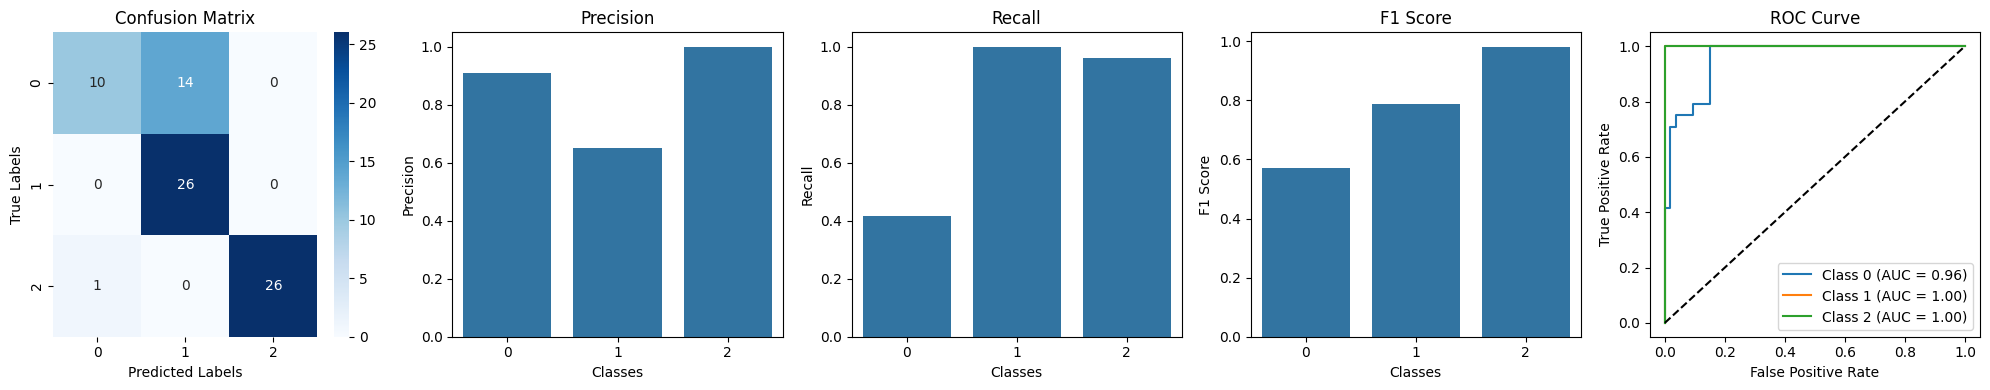

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# 在測試集上評估模型
loss, accuracy = model.evaluate(points_test, labels_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# 獲取測試集的預測結果
y_pred = model.predict(points_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(labels_test, axis=1)

# 創建一個包含5個子圖的圖形
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# 計算混淆矩陣並繪製圖形
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')
axes[0].set_title('Confusion Matrix')

# 計算精確率、召回率、F1分數並繪製圖形
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)
sns.barplot(x=list(report.keys())[:-3], y=[report[k]['precision'] for k in list(report.keys())[:-3]], ax=axes[1])
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision')

sns.barplot(x=list(report.keys())[:-3], y=[report[k]['recall'] for k in list(report.keys())[:-3]], ax=axes[2])
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('Recall')
axes[2].set_title('Recall')

sns.barplot(x=list(report.keys())[:-3], y=[report[k]['f1-score'] for k in list(report.keys())[:-3]], ax=axes[3])
axes[3].set_xlabel('Classes')
axes[3].set_ylabel('F1 Score')
axes[3].set_title('F1 Score')

# 計算ROC曲線並繪製圖形
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(np.unique(y_true_labels))):
    fpr[i], tpr[i], _ = roc_curve(labels_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(len(np.unique(y_true_labels))):
    axes[4].plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
axes[4].plot([0, 1], [0, 1], 'k--')
axes[4].set_xlabel('False Positive Rate')
axes[4].set_ylabel('True Positive Rate')
axes[4].set_title('ROC Curve')
axes[4].legend(loc='lower right')

# 調整子圖之間的間距
plt.tight_layout()

# 顯示圖形
plt.show()

# 建立隨機森林模型（使用關鍵點的角度、不使用關鍵點本身）

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
angles_data = np.array(data_dict[70]["angles"])
labels_data = np.array(data_dict[70]["labels"]).astype(int)
angles_data_2d = angles_data.reshape(angles_data.shape[0], -1)

print(angles_data_2d.shape, labels_data.shape)

angles_train, angles_test,  labels_train, labels_test  =  train_test_split(angles_data_2d, labels_data,  test_size=0.10)
angles_train, angles_valid, labels_train, labels_valid =  train_test_split(angles_train,   labels_train, test_size=0.10)

(761, 420) (761,)


In [124]:
# 創建隨機森林分類器
rf_model = RandomForestClassifier(n_estimators=100)

# 訓練模型
rf_model.fit(angles_train, labels_train)

# 在驗證集上進行預測
y_pred_valid = rf_model.predict(angles_valid)

# 在測試集上進行預測
y_pred_test = rf_model.predict(angles_test)

Test Accuracy: 0.8831


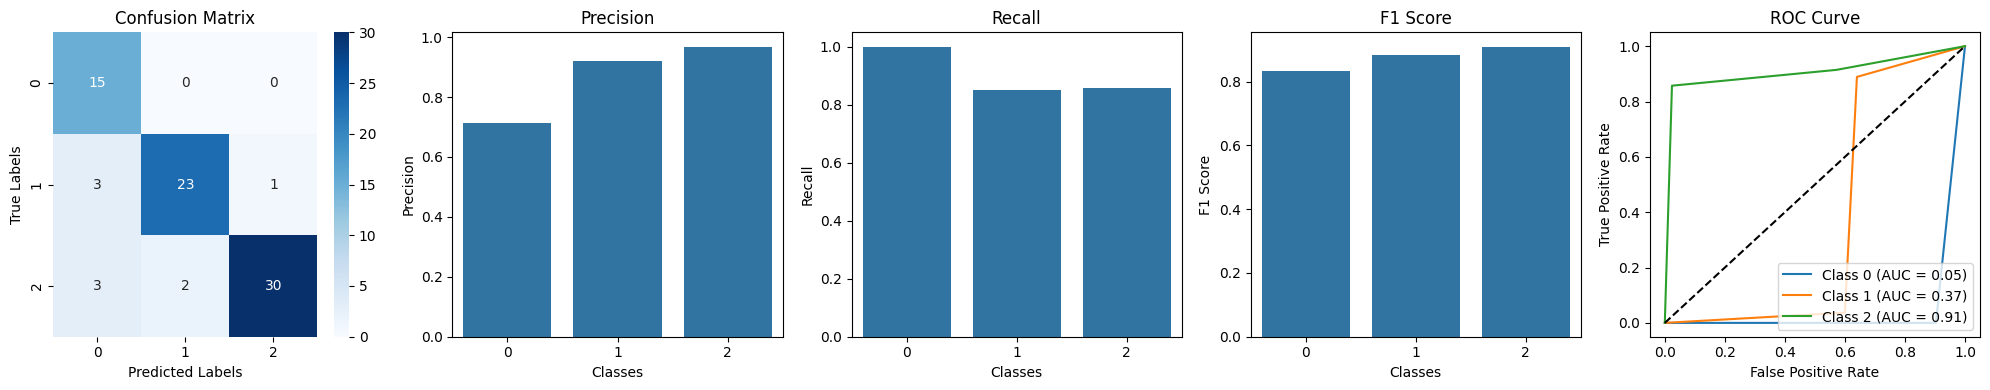

In [80]:
# 創建一個包含5個子圖的圖形
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

accuracy_test = accuracy_score(labels_test, y_pred_test)
print(f'Test Accuracy: {accuracy_test:.4f}')

# 計算混淆矩陣並繪製圖形
cm = confusion_matrix(labels_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')
axes[0].set_title('Confusion Matrix')

# 計算精確率、召回率、F1分數並繪製圖形
report = classification_report(labels_test, y_pred_test, output_dict=True)
sns.barplot(x=list(report.keys())[:-3], y=[report[k]['precision'] for k in list(report.keys())[:-3]], ax=axes[1])
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision')

sns.barplot(x=list(report.keys())[:-3], y=[report[k]['recall'] for k in list(report.keys())[:-3]], ax=axes[2])
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('Recall')
axes[2].set_title('Recall')

sns.barplot(x=list(report.keys())[:-3], y=[report[k]['f1-score'] for k in list(report.keys())[:-3]], ax=axes[3])
axes[3].set_xlabel('Classes')
axes[3].set_ylabel('F1 Score')
axes[3].set_title('F1 Score')

# 計算ROC曲線並繪製圖形
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(np.unique(labels_test))):
    fpr[i], tpr[i], _ = roc_curve(labels_test, y_pred_test, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(len(np.unique(labels_test))):
    axes[4].plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
axes[4].plot([0, 1], [0, 1], 'k--')
axes[4].set_xlabel('False Positive Rate')
axes[4].set_ylabel('True Positive Rate')
axes[4].set_title('ROC Curve')
axes[4].legend(loc='lower right')

# 調整子圖之間的間距
plt.tight_layout()

# 顯示圖形
plt.show()

# 非監督式學習 使用 K-Means

In [92]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Silhouette Score: 0.1122


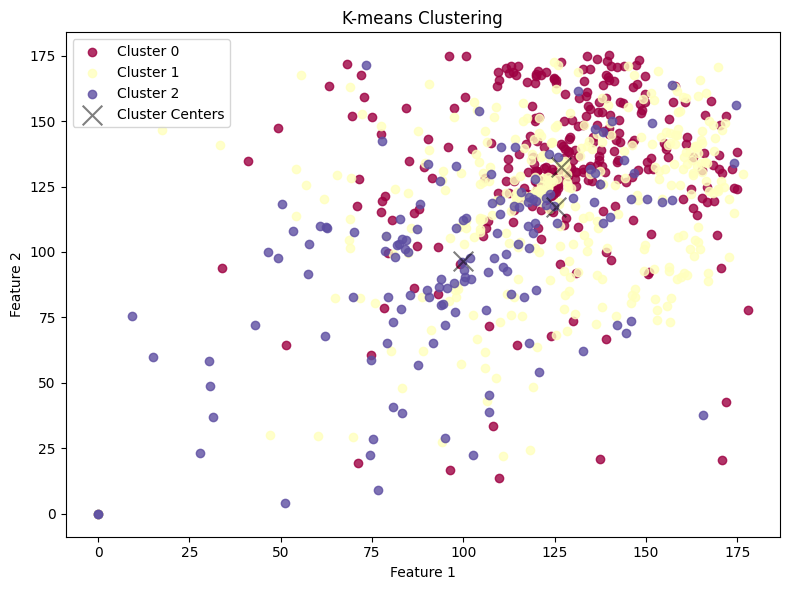

Clustering Accuracy: 0.4954


In [136]:
# 創建 KMeans 聚類模型
n_clusters = len(np.unique(labels_data))  # 設置聚類數量為標籤的唯一值數量
kmeans = KMeans(n_clusters=n_clusters)

# 訓練模型
kmeans.fit(angles_data_2d)

# 獲取聚類標籤
labels_pred = kmeans.labels_

# 評估聚類質量
silhouette_avg = silhouette_score(angles_data_2d, labels_pred)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# 可視化聚類結果
fig, ax = plt.subplots(figsize=(8, 6))

# 繪製散點圖，根據聚類標籤設置顏色
unique_labels = np.unique(labels_pred)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for label, color in zip(unique_labels, colors):
    mask = labels_pred == label
    ax.scatter(angles_data_2d[mask, 0], angles_data_2d[mask, 1], c=[color], label=f"Cluster {label}", alpha=0.8)

# 繪製聚類中心
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, marker='x', label='Cluster Centers')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('K-means Clustering')
ax.legend()

plt.tight_layout()
plt.show()

# 計算聚類標籤與真實標籤的匹配情況
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

# 計算聚類標籤與真實標籤的混淆矩陣
cm = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        cm[i, j] = np.sum((labels_pred == i) & (labels_data == j))

# 使用匈牙利算法找到最佳的聚類標籤與真實標籤的匹配
row_ind, col_ind = linear_sum_assignment(-cm)
labels_pred_matched = np.zeros_like(labels_pred)
for i in range(n_clusters):
    labels_pred_matched[labels_pred == row_ind[i]] = col_ind[i]

# 計算匹配後的準確率
accuracy = accuracy_score(labels_data, labels_pred_matched)
print(f"Clustering Accuracy: {accuracy:.4f}")

In [126]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Silhouette Score: 0.1457


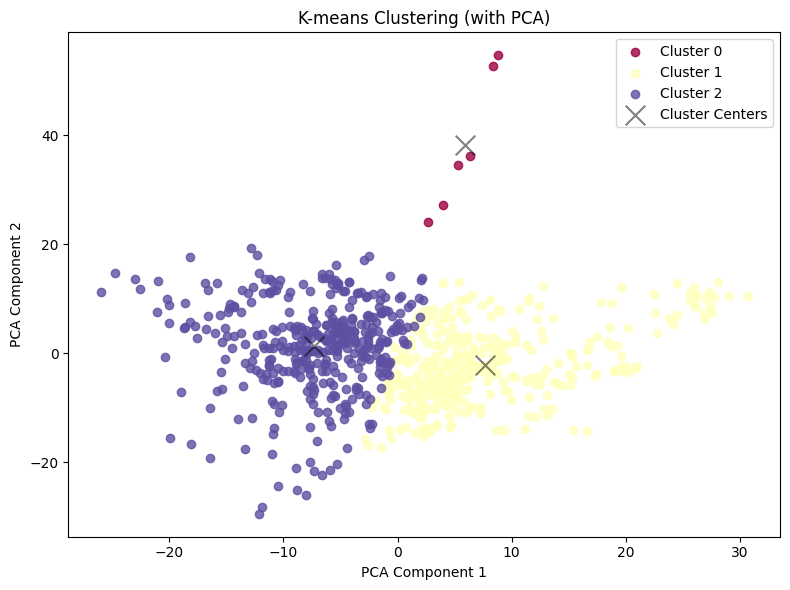

Clustering Accuracy: 0.5230


In [138]:
# 對特徵進行標準化
scaler = StandardScaler()
angles_data_scaled = scaler.fit_transform(angles_data_2d)

# 使用 PCA 進行降維
pca = PCA(n_components=0.95)  # 保留 95% 的方差
angles_data_pca = pca.fit_transform(angles_data_scaled)

# 創建 KMeans 聚類模型
n_clusters = len(np.unique(labels_data))  # 設置聚類數量為標籤的唯一值數量
kmeans = KMeans(n_clusters=n_clusters)

# 訓練模型
kmeans.fit(angles_data_pca)

# 獲取聚類標籤
labels_pred = kmeans.labels_

# 評估聚類質量
silhouette_avg = silhouette_score(angles_data_pca, labels_pred)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# 可視化聚類結果
fig, ax = plt.subplots(figsize=(8, 6))

# 繪製散點圖，根據聚類標籤設置顏色
unique_labels = np.unique(labels_pred)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for label, color in zip(unique_labels, colors):
    mask = labels_pred == label
    ax.scatter(angles_data_pca[mask, 0], angles_data_pca[mask, 1], c=[color], label=f"Cluster {label}", alpha=0.8)

# 繪製聚類中心
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, marker='x', label='Cluster Centers')

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_title('K-means Clustering (with PCA)')
ax.legend()

plt.tight_layout()
plt.show()

# 計算聚類標籤與真實標籤的匹配情況
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

# 計算聚類標籤與真實標籤的混淆矩陣
cm = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        cm[i, j] = np.sum((labels_pred == i) & (labels_data == j))

# 使用匈牙利算法找到最佳的聚類標籤與真實標籤的匹配
row_ind, col_ind = linear_sum_assignment(-cm)
labels_pred_matched = np.zeros_like(labels_pred)
for i in range(n_clusters):
    labels_pred_matched[labels_pred == row_ind[i]] = col_ind[i]

# 計算匹配後的準確率
accuracy = accuracy_score(labels_data, labels_pred_matched)
print(f"Clustering Accuracy: {accuracy:.4f}")

In [6]:
%load_ext tensorboard
%tensorboard --logdir logs --port=12345


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 12345 (pid 33548), started 0:01:23 ago. (Use '!kill 33548' to kill it.)